In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import tqdm
from sklearn.decomposition import PCA

import configs.deconv, configs.unet
from unet import UNet
from unet_deconv import UNetDeconv



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [2]:
def loss(output, target):
    return torch.nn.functional.mse_loss(output, target)

def train_loop(dataloader, model, loss_fn, optimizer, num_epochs=10):
    pbar = tqdm.tqdm(range(num_epochs), desc='Loss = N/A | Epochs')
    for _ in pbar:
        total_loss = 0
        for data in dataloader:
            pred = model(data)
            loss = loss_fn(pred, data)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pbar.set_description(f'Loss = {total_loss:.6f} | Epochs')

def evaluate_model(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in dataloader:
            pred = model(data)
            loss = loss_fn(pred, data)
            total_loss += loss.item()
    return total_loss / len(dataloader)

def analyze_latent_space(model, dataloader):
    model.eval()
    latent_vectors = []
    with torch.no_grad():
        for data in dataloader:
            latent = model.down(data)[-1]  # Extract bottleneck features
            latent_vectors.append(latent.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(latent_vectors.reshape(latent_vectors.shape[0], -1))

    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.5)
    plt.title("PCA of Latent Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

In [3]:
# Viewer function for visualization
def viewer(image, x, y, z):
    plt.gray()
    fig, ax = plt.subplots(1, 3)
    fig.tight_layout()

    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].imshow(image[:, :, z])
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('z')
    ax[1].imshow(np.flip(image[x, :, :].transpose()))
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('z')
    ax[2].imshow(image[:, y, :])
    ax[1].set_title(f"Slices at {x}, {y}, {z}")
    plt.show()


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load data
stripes_x = np.load("stripes_x_32x32.npy")
checkerboard_x = np.load("checkerboard_32x32.npy")

striped_dataset = stripes_x.astype(np.float32)
striped_dataset = np.expand_dims(striped_dataset, axis=0)
striped_dataset = np.expand_dims(striped_dataset, axis=0)
striped_dataset = torch.from_numpy(striped_dataset).to("cuda")
striped_dataloader = DataLoader(striped_dataset, batch_size=1, shuffle=True)

checkerboard_dataset = checkerboard_x.astype(np.float32)
checkerboard_dataset = np.expand_dims(checkerboard_dataset, axis=0)
checkerboard_dataset = np.expand_dims(checkerboard_dataset, axis=0)
checkerboard_dataset = torch.from_numpy(checkerboard_dataset).to("cuda")
checkerboard_dataloader = DataLoader(checkerboard_dataset, batch_size=1, shuffle=True)





In [12]:
# Initialize models
unet_model = UNet(**configs.unet.get_config().unet).to(device)
deconv_model = UNetDeconv(**configs.deconv.get_config().unet).to(device)

In [13]:
# Train models
print("Training UNet on striped patterns...")
train_loop(striped_dataloader, unet_model, loss, torch.optim.Adam(unet_model.parameters()), num_epochs=10)

print("Training DeconvUNet on checkerboard patterns...")
train_loop(checkerboard_dataloader, deconv_model, loss, torch.optim.Adam(deconv_model.parameters()), num_epochs=10)


Training UNet on striped patterns...


Loss = N/A | Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Down Block 0: Output irreps: 8x0e+4x1e+2x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Down Block 1: Output irreps: 16x0e+8x1e+4x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Down Block 2: Output irreps: 32x0e+16x1e+8x2e
Output from conv1: 112x0e+32x1e+16x2e
Output from conv2: 112x0e+32x1e+16x2e
Down Block 3: Output irreps: 64x0e+32x1e+16x2e
Downsampling Complete. Irreps at deepest layer: 64x0e+32x1e+16x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Up Block 0: Output irreps after conv block: 32x0e+16x1e+8x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Up Block 1: Output irreps after conv block: 16x0e+8x1e+4x2e
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Up Block 2: Output irreps after conv block: 8x0e+4x1e+2x2e
Upsampling Complete. Irreps after last up block: 8x0e+4x1e+2x2e
Final Ou

Loss = 1.803826 | Epochs:  10%|█         | 1/10 [00:00<00:06,  1.49it/s]

Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Down Block 0: Output irreps: 8x0e+4x1e+2x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Down Block 1: Output irreps: 16x0e+8x1e+4x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Down Block 2: Output irreps: 32x0e+16x1e+8x2e
Output from conv1: 112x0e+32x1e+16x2e
Output from conv2: 112x0e+32x1e+16x2e
Down Block 3: Output irreps: 64x0e+32x1e+16x2e
Downsampling Complete. Irreps at deepest layer: 64x0e+32x1e+16x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Up Block 0: Output irreps after conv block: 32x0e+16x1e+8x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Up Block 1: Output irreps after conv block: 16x0e+8x1e+4x2e
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Up Block 2: Output irreps after conv block: 8x0e+4x1e+2x2e
Upsampling Complete. Irreps after last up block: 8x0e+4x1e+2x2e
Final Ou

Loss = 1.662012 | Epochs:  20%|██        | 2/10 [00:01<00:04,  1.89it/s]

Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Down Block 0: Output irreps: 8x0e+4x1e+2x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Down Block 1: Output irreps: 16x0e+8x1e+4x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Down Block 2: Output irreps: 32x0e+16x1e+8x2e
Output from conv1: 112x0e+32x1e+16x2e
Output from conv2: 112x0e+32x1e+16x2e
Down Block 3: Output irreps: 64x0e+32x1e+16x2e
Downsampling Complete. Irreps at deepest layer: 64x0e+32x1e+16x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Up Block 0: Output irreps after conv block: 32x0e+16x1e+8x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Up Block 1: Output irreps after conv block: 16x0e+8x1e+4x2e
Output from conv1: 14x0e+4x1e+2x2e


Loss = 1.462227 | Epochs:  30%|███       | 3/10 [00:03<00:10,  1.52s/it]

Output from conv2: 14x0e+4x1e+2x2e
Up Block 2: Output irreps after conv block: 8x0e+4x1e+2x2e
Upsampling Complete. Irreps after last up block: 8x0e+4x1e+2x2e
Final Output Irreps: 1x0e
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Down Block 0: Output irreps: 8x0e+4x1e+2x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Down Block 1: Output irreps: 16x0e+8x1e+4x2e


Loss = 1.208703 | Epochs:  40%|████      | 4/10 [00:03<00:05,  1.02it/s]

Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Down Block 2: Output irreps: 32x0e+16x1e+8x2e
Output from conv1: 112x0e+32x1e+16x2e
Output from conv2: 112x0e+32x1e+16x2e
Down Block 3: Output irreps: 64x0e+32x1e+16x2e
Downsampling Complete. Irreps at deepest layer: 64x0e+32x1e+16x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Up Block 0: Output irreps after conv block: 32x0e+16x1e+8x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Up Block 1: Output irreps after conv block: 16x0e+8x1e+4x2e
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Up Block 2: Output irreps after conv block: 8x0e+4x1e+2x2e
Upsampling Complete. Irreps after last up block: 8x0e+4x1e+2x2e
Final Output Irreps: 1x0e
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Down Block 0: Output irreps: 8x0e+4x1e+2x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Down Block 1: Output irreps

Loss = 1.075572 | Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.98it/s]

Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Down Block 0: Output irreps: 8x0e+4x1e+2x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Down Block 1: Output irreps: 16x0e+8x1e+4x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Down Block 2: Output irreps: 32x0e+16x1e+8x2e
Output from conv1: 112x0e+32x1e+16x2e
Output from conv2: 112x0e+32x1e+16x2e
Down Block 3: Output irreps: 64x0e+32x1e+16x2e
Downsampling Complete. Irreps at deepest layer: 64x0e+32x1e+16x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Up Block 0: Output irreps after conv block: 32x0e+16x1e+8x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Up Block 1: Output irreps after conv block: 16x0e+8x1e+4x2e
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Up Block 2: Output irreps after conv block: 8x0e+4x1e+2x2e
Upsampling Complete. Irreps after last up block: 8x0e+4x1e+2x2e
Final Ou

Loss = 0.985352 | Epochs:  70%|███████   | 7/10 [00:04<00:01,  2.58it/s]

Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Up Block 1: Output irreps after conv block: 16x0e+8x1e+4x2e
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Up Block 2: Output irreps after conv block: 8x0e+4x1e+2x2e
Upsampling Complete. Irreps after last up block: 8x0e+4x1e+2x2e
Final Output Irreps: 1x0e
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Down Block 0: Output irreps: 8x0e+4x1e+2x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Down Block 1: Output irreps: 16x0e+8x1e+4x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Down Block 2: Output irreps: 32x0e+16x1e+8x2e
Output from conv1: 112x0e+32x1e+16x2e
Output from conv2: 112x0e+32x1e+16x2e
Down Block 3: Output irreps: 64x0e+32x1e+16x2e
Downsampling Complete. Irreps at deepest layer: 64x0e+32x1e+16x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Up Block 0: Output irreps after conv block:

Loss = 0.841899 | Epochs:  90%|█████████ | 9/10 [00:04<00:00,  3.82it/s]

Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Down Block 0: Output irreps: 8x0e+4x1e+2x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Down Block 1: Output irreps: 16x0e+8x1e+4x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Down Block 2: Output irreps: 32x0e+16x1e+8x2e
Output from conv1: 112x0e+32x1e+16x2e
Output from conv2: 112x0e+32x1e+16x2e
Down Block 3: Output irreps: 64x0e+32x1e+16x2e
Downsampling Complete. Irreps at deepest layer: 64x0e+32x1e+16x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Up Block 0: Output irreps after conv block: 32x0e+16x1e+8x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Up Block 1: Output irreps after conv block: 16x0e+8x1e+4x2e
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Up Block 2: Output irreps after conv block: 8x0e+4x1e+2x2e
Upsampling Complete. Irreps after last up block: 8x0e+4x1e+2x2e
Final Ou

Loss = 0.809125 | Epochs: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Up Block 2: Output irreps after conv block: 8x0e+4x1e+2x2e
Upsampling Complete. Irreps after last up block: 8x0e+4x1e+2x2e
Final Output Irreps: 1x0e
Training DeconvUNet on checkerboard patterns...


Loss = 0.262880 | Epochs: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


In [15]:
# Evaluate models
print("Evaluating UNet on striped patterns...")
unet_loss = evaluate_model(striped_dataloader, unet_model, loss)
print(f"UNet Reconstruction Loss: {unet_loss}")

print("Evaluating UNet on checkerboard patterns...")
deconv_loss = evaluate_model(checkerboard_dataloader, unet_model, loss)
print(f"UNet Reconstruction Loss: {deconv_loss}")

print("Evaluating DeconvUNet on striped patterns...")
deconv_loss = evaluate_model(striped_dataloader, deconv_model, loss)
print(f"DeconvUNet Reconstruction Loss: {deconv_loss}")


print("Evaluating DeconvUNet on checkerboard patterns...")
deconv_loss = evaluate_model(checkerboard_dataloader, deconv_model, loss)
print(f"DeconvUNet Reconstruction Loss: {deconv_loss}")


Evaluating UNet on striped patterns...
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Down Block 0: Output irreps: 8x0e+4x1e+2x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Down Block 1: Output irreps: 16x0e+8x1e+4x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Down Block 2: Output irreps: 32x0e+16x1e+8x2e
Output from conv1: 112x0e+32x1e+16x2e
Output from conv2: 112x0e+32x1e+16x2e
Down Block 3: Output irreps: 64x0e+32x1e+16x2e
Downsampling Complete. Irreps at deepest layer: 64x0e+32x1e+16x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Up Block 0: Output irreps after conv block: 32x0e+16x1e+8x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Up Block 1: Output irreps after conv block: 16x0e+8x1e+4x2e
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Up Block 2: Output irreps after conv block: 8x0e+4x1e+2x2e
Upsampling Complete. Irreps after

Analyzing latent space for UNet...
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Down Block 0: Output irreps: 8x0e+4x1e+2x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Down Block 1: Output irreps: 16x0e+8x1e+4x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Down Block 2: Output irreps: 32x0e+16x1e+8x2e
Output from conv1: 112x0e+32x1e+16x2e
Output from conv2: 112x0e+32x1e+16x2e
Down Block 3: Output irreps: 64x0e+32x1e+16x2e


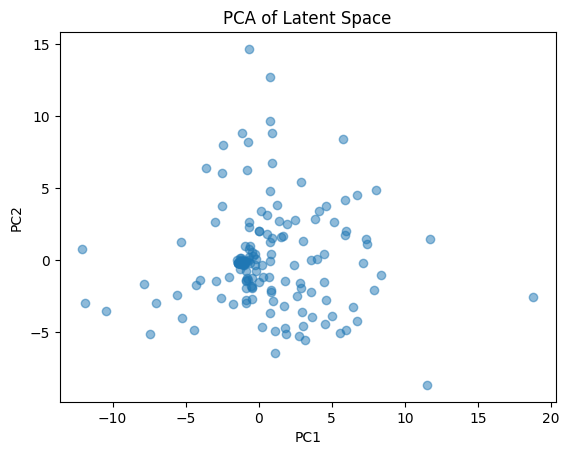

Analyzing latent space for UNet...
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Down Block 0: Output irreps: 8x0e+4x1e+2x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Down Block 1: Output irreps: 16x0e+8x1e+4x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Down Block 2: Output irreps: 32x0e+16x1e+8x2e
Output from conv1: 112x0e+32x1e+16x2e
Output from conv2: 112x0e+32x1e+16x2e
Down Block 3: Output irreps: 64x0e+32x1e+16x2e


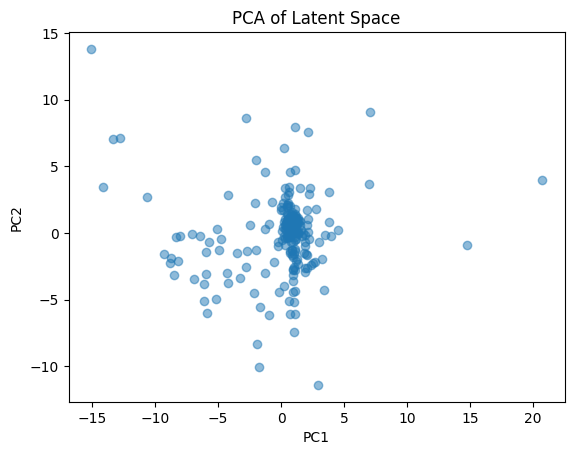

Analyzing latent space for DeconvUNet...


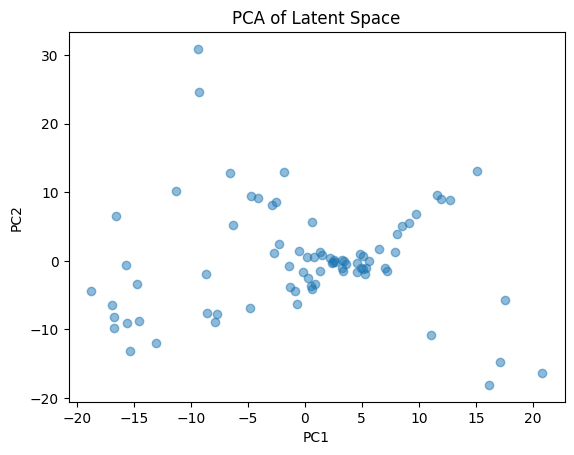

Analyzing latent space for DeconvUNet...


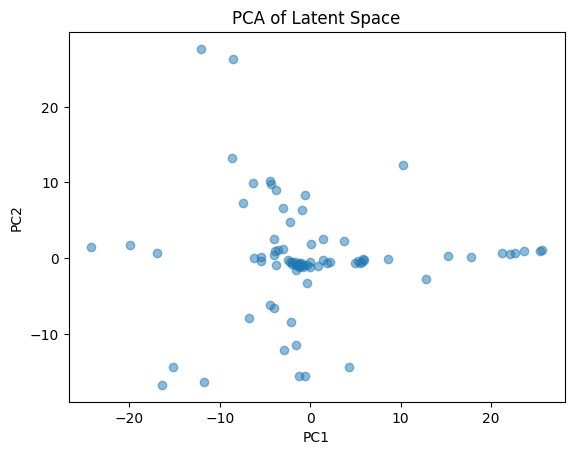

In [17]:
# Analyze latent space
print("Analyzing latent space for UNet...")
analyze_latent_space(unet_model, striped_dataloader)

print("Analyzing latent space for UNet...")
analyze_latent_space(unet_model, checkerboard_dataloader)

print("Analyzing latent space for DeconvUNet...")
analyze_latent_space(deconv_model, striped_dataloader)

print("Analyzing latent space for DeconvUNet...")
analyze_latent_space(deconv_model, checkerboard_dataloader)

Visualizing original and reconstructed patterns...


<Figure size 640x480 with 0 Axes>

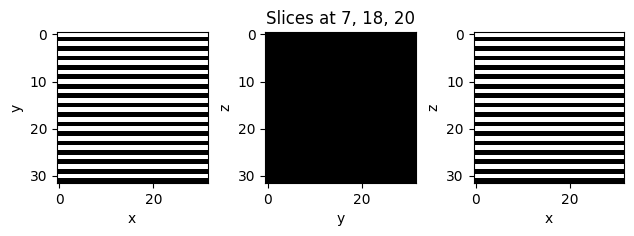

Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Down Block 0: Output irreps: 8x0e+4x1e+2x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Down Block 1: Output irreps: 16x0e+8x1e+4x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Down Block 2: Output irreps: 32x0e+16x1e+8x2e
Output from conv1: 112x0e+32x1e+16x2e
Output from conv2: 112x0e+32x1e+16x2e
Down Block 3: Output irreps: 64x0e+32x1e+16x2e
Downsampling Complete. Irreps at deepest layer: 64x0e+32x1e+16x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Up Block 0: Output irreps after conv block: 32x0e+16x1e+8x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Up Block 1: Output irreps after conv block: 16x0e+8x1e+4x2e
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Up Block 2: Output irreps after conv block: 8x0e+4x1e+2x2e
Upsampling Complete. Irreps after last up block: 8x0e+4x1e+2x2e
Final Ou

<Figure size 640x480 with 0 Axes>

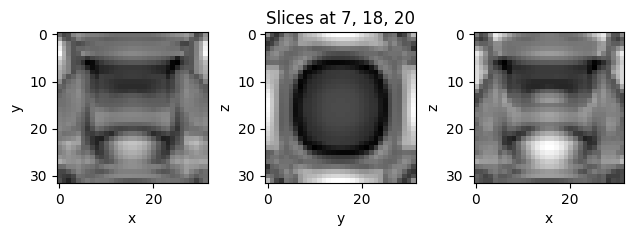

<Figure size 640x480 with 0 Axes>

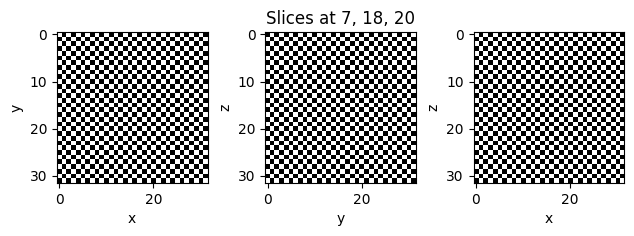

Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Down Block 0: Output irreps: 8x0e+4x1e+2x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Down Block 1: Output irreps: 16x0e+8x1e+4x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Down Block 2: Output irreps: 32x0e+16x1e+8x2e
Output from conv1: 112x0e+32x1e+16x2e
Output from conv2: 112x0e+32x1e+16x2e
Down Block 3: Output irreps: 64x0e+32x1e+16x2e
Downsampling Complete. Irreps at deepest layer: 64x0e+32x1e+16x2e
Output from conv1: 56x0e+16x1e+8x2e
Output from conv2: 56x0e+16x1e+8x2e
Up Block 0: Output irreps after conv block: 32x0e+16x1e+8x2e
Output from conv1: 28x0e+8x1e+4x2e
Output from conv2: 28x0e+8x1e+4x2e
Up Block 1: Output irreps after conv block: 16x0e+8x1e+4x2e
Output from conv1: 14x0e+4x1e+2x2e
Output from conv2: 14x0e+4x1e+2x2e
Up Block 2: Output irreps after conv block: 8x0e+4x1e+2x2e
Upsampling Complete. Irreps after last up block: 8x0e+4x1e+2x2e
Final Ou

<Figure size 640x480 with 0 Axes>

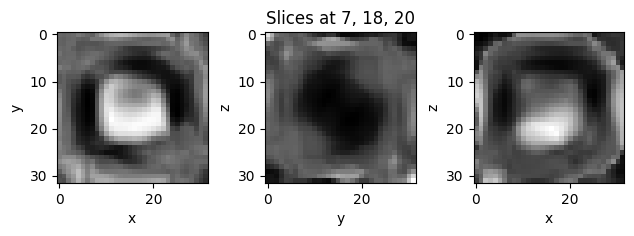

<Figure size 640x480 with 0 Axes>

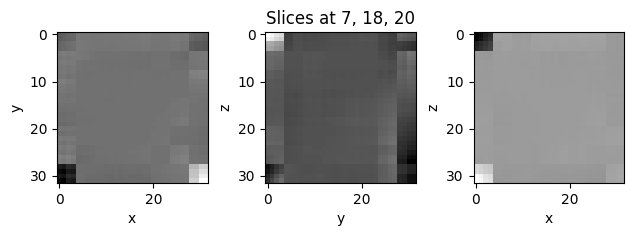

<Figure size 640x480 with 0 Axes>

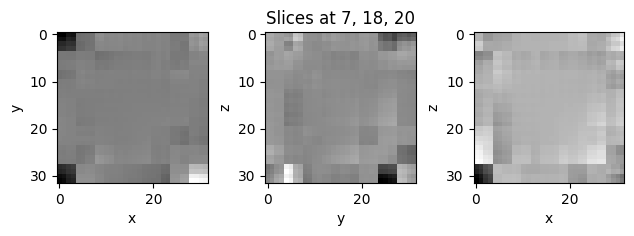

In [19]:
# Visualize reconstruction
x, y, z = 7, 18, 20
print("Visualizing original and reconstructed patterns...")
# Unet model on striped and checkered datasets
viewer(striped_dataset[0, 0].cpu().numpy(), x, y, z)
viewer(unet_model(striped_dataset[0:1]).cpu().detach().numpy()[0, 0], x, y, z)
viewer(checkerboard_dataset[0, 0].cpu().numpy(), x, y, z)
viewer(unet_model(checkerboard_dataset[0:1]).cpu().detach().numpy()[0, 0], x, y, z)

# Deconv model on striped and checkered datasets
viewer(deconv_model(striped_dataset[0:1]).cpu().detach().numpy()[0, 0], x, y, z)
viewer(deconv_model(checkerboard_dataset[0:1]).cpu().detach().numpy()[0, 0], x, y, z)